Load in all the needed libraries.

In [2]:
import requests
from requests.adapters import HTTPAdapter
import json

import pandas as pd
from bs4 import BeautifulSoup as soup
from playwright.async_api import async_playwright
from playwright.sync_api import sync_playwright
import time
import numpy as np
import re

In [8]:
data = pd.read_csv('species-listings-by-tax-group-report.csv')
data.head(5)

# Rename columns scientific_name, common_name, listing_location, listing_region, esa_status and group
data.columns = ['scientific_name', 'common_name', 'listing_location', 'listing_region', 'esa_status', 'group']
data.drop_duplicates(subset=['scientific_name'])

,scientific_name,common_name,listing_location,listing_region,esa_status,group
0,Nerodia clarkii taeniata,Atlantic salt marsh snake,Wherever found,4,Threatened,Reptiles
1,Drosophila differens,Hawaiian picture-wing fly,Wherever found,1,Endangered,Insects
2,Ammodramus savannarum floridanus,Florida grasshopper sparrow,Wherever found,4,Endangered,Birds
3,Corvus leucognaphalus,White-necked crow,Wherever found,4,Endangered,Birds
4,Fusconaia cuneolus,Finerayed pigtoe,Wherever found; Except where listed as Experim...,4,Endangered,Clams
...,...,...,...,...,...,...
729,Rostrhamus sociabilis plumbeus,Everglade snail kite,Wherever found,4,Endangered,Birds
730,Hemignathus affinis,Maui nukupuu,Wherever found,1,Endangered,Birds
731,Thermosphaeroma thermophilus,Socorro isopod,Wherever found,2,Endangered,Crustaceans
732,Strix occidentalis caurina,Northern spotted owl,Wherever found,1,Threatened,Birds


In [9]:
# Drop if their are birds, mammals, arachnids, insects and reptiles
df = data.loc[(data['group'] != 'Birds') & (data['group'] != 'Mammals') & (data['group'] != 'Arachnids') & (data['group'] != 'Insects') & (data['group'] != 'Reptiles') & (data['group'] != 'Amphibians')]


In [10]:
df.groupby(['listing_region']).size().reset_index(name='count')

,listing_region,count
0,1,23
1,2,49
2,3,19
3,4,186
4,5,20
5,6,15
6,8,37


In [5]:
# drop rows that are not in listing region 4
df = df.loc[(data['listing_region'] == 4)]

df

,scientific_name,common_name,listing_location,listing_region,esa_status,group
4,Fusconaia cuneolus,Finerayed pigtoe,Wherever found; Except where listed as Experim...,4,Endangered,Clams
7,Medionidus acutissimus,Alabama moccasinshell,Wherever found,4,Threatened,Clams
9,Fusconaia masoni,Atlantic pigtoe,Wherever found,4,Threatened,Clams
10,Pleurocera foremani,Rough hornsnail,Wherever found,4,Endangered,Snails
14,Epioblasma metastriata,Upland combshell,Wherever found,4,Endangered,Clams
...,...,...,...,...,...,...
689,Leptoxis foremani,Interrupted (=Georgia) Rocksnail,Wherever found,4,Endangered,Snails
695,Obovaria subrotunda,Round hickorynut,Wherever found,4,Threatened,Clams
709,Pleurobema perovatum,Ovate clubshell,Wherever found,4,Endangered,Clams
725,Cyprinella caerulea,Blue shiner,Wherever found,4,Threatened,Fishes


In [ ]:
# save the data to a csv file called south.csv
df.to_csv('south.csv', index=False)

### Create a small scraper that gets the link for each species page to get more information

## Prepare data for exploratory visualization

In [23]:
# Group data by taxonomic group and region and count the number of species in each group
data.groupby(['listing_region']).size().reset_index(name='count')

,listing_region,count
0,1,130
1,2,110
2,3,36
3,4,277
4,5,30
5,6,29
6,7,8
7,8,114


In [ ]:
# Group data by taxonomic group and region and count the number of species in each group
grouped = data.groupby(['listing_region','group']).size().reset_index(name='count')
grouped

In [9]:
# create a new column which is true if listing_region is 4
grouped['is_4'] = grouped['listing_region'] == 4

In [10]:
grouped_status = data.groupby(['listing_region','group','esa_status']).size().reset_index(name='count')
grouped_status.head(50)

,listing_region,group,esa_status,count
0,1,Amphibians,Threatened,1
1,1,Arachnids,Endangered,1
2,1,Birds,Endangered,42
3,1,Birds,"Experimental Population, Non-Essential",2
4,1,Birds,Threatened,6
5,1,Crustaceans,Endangered,3
6,1,Fishes,Endangered,1
7,1,Fishes,Threatened,3
8,1,Insects,Endangered,33
9,1,Insects,Threatened,3


In [9]:
# create a new column which is true if listing_region is 4
grouped_status['is_4'] = grouped_status['listing_region'] == 4

In [10]:
data = pd.read_csv('south_links.csv')
data.head(2)

,scientific_name,common_name,listing_location,listing_region,esa_status,group,Url
0,Acipenser oxyrinchus (=oxyrhynchus) desotoi,Gulf sturgeon,Wherever found,4,Threatened,Fishes,https://ecos.fws.gov/ecp/species/651
1,Alasmidonta atropurpurea,Cumberland elktoe,Wherever found,4,Endangered,Clams,https://ecos.fws.gov/ecp/species/1248


In [11]:
# Turn the url column into a list
links = data['Url'].tolist()

In [12]:
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless = False)
page = await browser.new_page()

In [13]:
url = links[0]
await page.goto(url)

for link in links:
    try:
        await page.goto(link)
        time.sleep(5)
        async with page.expect_download() as download_info:
            await page.locator("#j-populations-occurrence > div > a > i").click()
        download = await download_info.value
        # Wait for the download process to complete
        print(await download.path())
        # Save downloaded file somewhere
        await download.save_as("/Users/laurabejderjensen/Library/Mobile Documents/com~apple~CloudDocs/Desktop - Laura’s MacBook Pro/GitHub/masters-project/shapefiles")
    except:
        pass

## Exploratory data analysis

In [ ]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [ ]:
%%R

require('tidyverse')

R[write to console]: Loading required package: tidyverse



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


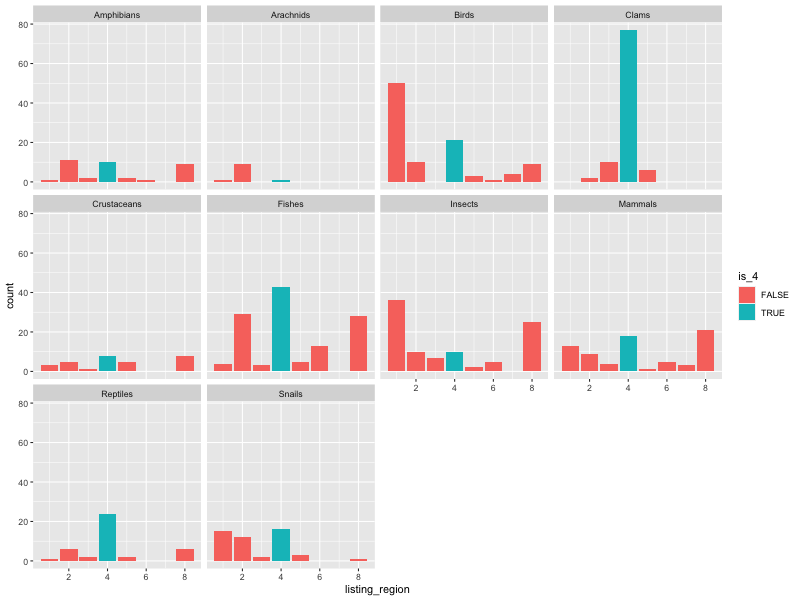

In [ ]:
%%R -i grouped -w 800 -h 600

ggplot(grouped, aes(x = listing_region, y = count, fill = is_4)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_wrap(~group, ncol=4)

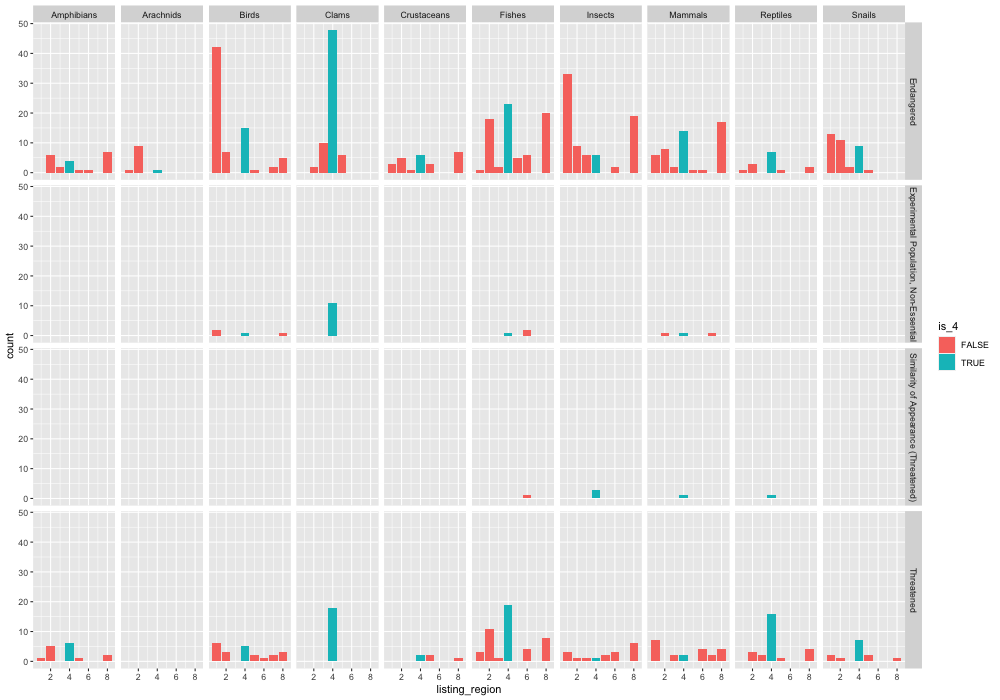

In [ ]:
%%R -i grouped_status -h 700 -w 1000

ggplot(grouped_status, aes(x = listing_region, y = count, fill = is_4)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(esa_status ~ group)